In [8]:
import pandas as pd
from pandas import DataFrame
from datetime import date
import calendar
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
import time
import math
from IPython.display import display, HTML
from bs4 import BeautifulSoup
import requests
%matplotlib inline

cd = os.path.split(os.getcwd())[0]
if cd not in sys.path:
    sys.path.append(cd)

from lib import noaa, bexarcrime


# Set this to true if you want to run it from scratch
# IE pulling all the data from source and running all the slow
# functions
PROCESS_FULLY = False

# Table of Contents
* [City Selection](#selection)
  * [Loading](#loading)
  * [Merging](#merging)
  * [Visualisations](#visualisations)
* [Data Acquisition](#acquisition)
* [Data Analysis](#analysis)
  * [Hypthesis](#hypothesis)
  * [Exploration](#exploration)
* [Results and Conclusions](#results)

### Loading <a class="anchor" id="loading"></a>

County-level crime dataset

In [9]:
if PROCESS_FULLY:
    # using crime reports, not arrests 
    crime = pd.read_csv('../data/CountyCrimeReports.tsv', sep='\t')
    crime['FIPS'] = crime['FIPS_ST'] * 1000 + crime['FIPS_CTY']
    crime['vcrime'] = crime['MURDER'] + crime['RAPE'] + crime['ROBBERY'] + crime['AGASSLT']
    crime = crime.set_index('FIPS')
    crime = crime[['COVIND', 'vcrime']]

Education dataset

In [10]:
if PROCESS_FULLY:
    edu = pd.read_excel('../data/Education.xls', skiprows=4)

    # state and areas are named nicely in this dataset and will be kept for the later 'join'
    # columns[-4:] include most recent data for adults eduction
    # I chose the most recent because its not like the total number of HS dropouts is going to change THAT much
    edu = edu[['FIPS Code', 'State', 'Area name'] + list(edu.columns[-4:])]
    edu.rename(columns={'FIPS Code':'FIPS', \
                        'Area name':'County',\
                        'Percent of adults with less than a high school diploma, 2011-2015':'p_no_HS_dip', \
                        'Percent of adults with a high school diploma only, 2011-2015':'p_HS_dip',\
                        'Percent of adults completing some college or associate\'s degree, 2011-2015':'p_some_college',\
                        'Percent of adults with a bachelor\'s degree or higher, 2011-2015':'p_college_dip'}, inplace=True)
    edu = edu.set_index('FIPS')

Population dataset

In [11]:
if PROCESS_FULLY:
    pop = pd.read_excel('../data/PopulationEstimates.xls', skiprows=2)

    # average the columns
    cols = ['POP_ESTIMATE_2010','POP_ESTIMATE_2011','POP_ESTIMATE_2012','POP_ESTIMATE_2013','POP_ESTIMATE_2014','POP_ESTIMATE_2015','POP_ESTIMATE_2016']
    pop['avgpop'] = pop[cols].sum(axis=1) / len(cols)

    # more averaging
    cols = ['N_POP_CHG_2010','N_POP_CHG_2011','N_POP_CHG_2012','N_POP_CHG_2013','N_POP_CHG_2014','N_POP_CHG_2015','N_POP_CHG_2016']
    pop['dpop/dt'] = pop[cols].sum(axis=1) / len(cols)

    # only pull FIPS code, population, and dp
    pop = pop[['FIPS', 'avgpop', 'dpop/dt']]
    pop = pop.set_index('FIPS')    

Poverty estimate dataset

In [12]:
if PROCESS_FULLY:
    pov = pd.read_excel('../data/PovertyEstimates.xls', skiprows=3)
    # only select poverty percentage
    pov = pov[['FIPStxt', 'PCTPOVALL_2015']]
    pov.rename(columns={'FIPStxt':'FIPS', 'PCTPOVALL_2015':'p_impoverished'}, inplace=True)
    pov = pov.set_index('FIPS')
    pov.p_impoverished = pd.to_numeric(pov.p_impoverished, errors='coerce')

Employment estimates dataset

In [13]:
if PROCESS_FULLY:
    emp = pd.read_excel('../data/Unemployment.xls', skiprows=9)

    #avg unemployment
    cols = ['Unemployment_rate_2007', 'Unemployment_rate_2008', 'Unemployment_rate_2009', 'Unemployment_rate_2010', 'Unemployment_rate_2011', 'Unemployment_rate_2012', 'Unemployment_rate_2013', 'Unemployment_rate_2014', 'Unemployment_rate_2015', 'Unemployment_rate_2016']
    emp['p_unempl'] = emp[cols].sum(axis=1) / len(cols)

    #only pull average and income
    emp = emp[['FIPStxt', 'p_unempl', 'Median_Household_Income_2015']]
    emp.rename(columns={'FIPStxt':'FIPS', 'Median_Household_Income_2015':'med_income'}, inplace=True)
    emp = emp.set_index('FIPS')

### Merging <a class="anchor" id="merging"></a>

Merge the datasets into a single one, and take out country- and state-wide data

In [14]:
if PROCESS_FULLY:
    df = edu.join([pop,pov,emp,crime], how='outer')
    df = df.where(df.State != 'PR').dropna(how='all') ## Puerto Rico has unreliable data

    #pull out nationwide data
    us = df.iloc[0]
    df = df.drop(0)
    
    #pull out statewide data
    s = [x for x in range(1000,75000,1000)]
    states = df.loc[s].dropna(how='all')

    # all thats left is county level data
    df = df.drop(states.index)

Normalize the merged datasets, violent crime is violentcrime per 100,00 residents

In [15]:
if PROCESS_FULLY:
    #normalizing data
    df['p_dpop'] = df['dpop/dt']/df['avgpop']
    df['vcrime_rate'] = 100000 * df['vcrime']/df['avgpop']
    df = df.drop(['dpop/dt', 'vcrime'], axis=1)

### Visualisations <a class="anchor" id="visualisations"></a>

Basic statistics of the county-level dataset

In [16]:
if PROCESS_FULLY:
        display(df.corr())

In [17]:
if PROCESS_FULLY:
        display(df.describe())

Comparison of different states, with bonus political standpoints according the the 2008 presidential election between Barack Obama and John McCain

Box plot of violent crime rate per state

In [18]:
if PROCESS_FULLY:
    # According to the 2008 presidential election
    blue_states =['WA', 'OR', 'CA', 'NV', 'NM', 'CO', 'MN', 'IA', 'WI', 'IL', 'IN', 'MI', 'OH', 'PA', 'NY', 'VT', 'NH', 'ME', 'MA', 'CT', 'RI', 'NJ', 'DE', 'MD', 'VA', 'NC', 'FL', 'HI']
    red_states = ['ID', 'MT', 'WY', 'UT', 'AZ', 'ND', 'SD', 'NE', 'KS', 'OK', 'TX', 'MO', 'AR', 'LA', 'WV', 'KY', 'TN', 'MS', 'AL', 'GA', 'SC', 'AK']
    fix, ax = plt.subplots(figsize=(20,10))
    pal = {state: 'r' if state in red_states else "b" for state in df.State}
    sns.boxplot(ax=ax, x='State', y='vcrime_rate', data=df, palette=pal)

Box plot of percentages without a highschool diploma

In [19]:
if PROCESS_FULLY:
    fig, ax = plt.subplots(figsize=(20,10))
    sns.boxplot(ax=ax, x='State', y='p_no_HS_dip', data=df, palette=pal)

Graphs of factors to violent crime

In [20]:
if PROCESS_FULLY:
    sns.pairplot(df, y_vars=['vcrime_rate'], x_vars=['p_no_HS_dip', 'p_HS_dip', 'p_some_college', 'p_college_dip', 'avgpop',
       'p_impoverished', 'p_unempl', 'med_income', 'p_dpop', 'vcrime_rate'], dropna=True, size=10)

In [21]:
if PROCESS_FULLY:
    sns.distplot(df.vcrime_rate.dropna(), axlabel="Violent crime per 100,000")

In [22]:
if PROCESS_FULLY:
    sns.distplot(df.avgpop.dropna().apply(np.log10), axlabel="Population (log10)")

In [23]:
if PROCESS_FULLY:
    sns.distplot(df.p_unempl.dropna(), axlabel='Unemployment Rate')

In [24]:
if PROCESS_FULLY:
    sns.distplot(df.p_impoverished.dropna(), axlabel="Poverty Rate")

Bin the data into high, medium and low (based on national quantiles)

In [25]:
if PROCESS_FULLY:
    binned = pd.DataFrame({c : pd.qcut(df[c], 3, labels=['L', 'M', 'H']) for c in df.drop(['State', 'County', 'COVIND'], axis=1).columns}).join(df[['State', 'County', 'COVIND']])

Table of the five worst counties in Texas (based on high rates of unemployment, crime, and population. Half of them are border towns with immigration problems

In [26]:
if PROCESS_FULLY:
    TX = binned.dropna(how='all').groupby(['vcrime_rate', 'p_unempl', 'avgpop'])
    display(df.loc[TX.get_group(('H', 'H', 'H')).index].where(df.State == 'TX').dropna())

Graph of how Texas matches up nationwide to crime

In [27]:
if PROCESS_FULLY:
    sns.distplot(df.where(df.State=='TX').vcrime_rate.dropna(), label="Violent Crime Rates in Texas")
    sns.distplot(df.vcrime_rate.dropna(), axlabel="Violent Crime Rates in US and Texas")

Table of the highest crime rates in the US with at least a population of 10000 to cull outliers. Note that high city crime does not necessarily match high county crime. For example, Chicago is a high crime city, but because it's split between two counties it's ranked lower on this list. St. Louis, however, is both a city and its own county, so it's data is more precise

In [28]:
if PROCESS_FULLY:
    display(df.where(df.avgpop > 10000).sort_values('vcrime_rate', ascending=False)[:20])

We grouped the data by violent crime rate, poverty rate, unemployment rate, and population.

We select counties with high rates of enemployment, violent crime, poverty, and large populations sampled using a nonrandom seed for consistency between runs.

In [29]:
if PROCESS_FULLY:
    # all counties grouped by H/M/L rates of each factor
    c = binned.dropna(how='all').groupby(groups[::-1])
    display(c.count().where(c.count().State > 10).dropna().sort_values('State', ascending=False)['State'].unstack())

In [30]:
if PROCESS_FULLY:
    groups = ['vcrime_rate', 'p_impoverished', 'p_unempl', 'avgpop']
    
    selection = ('H','H','H', 'H')
    for x in groups:
        print("%10s " %x[:10], end='')
    print('')
    for x in selection:
        print("%10s " %x[:10], end='')
    HHHstates = df.loc[c.get_group(selection).index]
    display(HHHstates.where(HHHstates.vcrime_rate > 800).dropna().sample(10, random_state=15))

From those counties, we selected the county seats as the cities
We looked up the latitude and longitude of them to match to NOAA's list of weather stations. We used Pythagoras' theorem to find the closest station to the city, as some cities may not have one within city limits.

In [31]:
if PROCESS_FULLY:
    cities = {
        'Philidelphia, PA' : (39.9526, -75.1652), #Philadelphia County
        'Albany, GA' : (31.5785, -84.1557), # Gougherty County
        'Memphis, TN' : (35.1495, -90.0490), # Shelby County and Crittenden County
        'Toledo, OH' : (41.6639, -83.5552), # Lucas County
        'Pine Bluff AR' : (34.2284, -92.0032), # Jefferson County
        'Detroit, MI' : (42.3314, -83.0458), # Wayne County
        'Baltimore, MD' : (39.2904, -76.6122), # Baltimore City
        'Flint, MI' : (43.0125, -83.6875), # Genesee County
        'St. Louis, MO' : (38.6270, -90.1994) # St. Louis City
    }

Then we cross-referenced those locations with the NOAA ISD dataset to find the nearest stations.

The stations were filtered such that we only selected stations that had recent (more recent than 2012) data.

In [32]:
if PROCESS_FULLY:
    # list of stations with location, name, and recording beginning and end dates
    hist = pd.read_csv('ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv')
    # only recent stations
    hist = hist.where(hist.END > 20120101 ).dropna(how='all')

We defined some helper functions to process the station codes

In [33]:
def dist(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [34]:
def format_station_code(usaf, wban):
    usafstr = str(int(usaf))
    wbanstr = str(int(wban))
    
    if len(usafstr) < 6:
        usafstr = '0'*(6-len(usafstr)) + usafstr
        
    if len(wbanstr) < 5:
        wbanstr = '0'*(5-len(wbanstr)) + wbanstr
        
    return usafstr + '-' + wbanstr

In [35]:
if PROCESS_FULLY:
    stations = dict()
    for city in cities.keys():
        coord = cities[city]
        mindist = 999
        minindex = 0
        for index, row in hist.iterrows():
            d = dist(coord, (row['LAT'], row['LON']))
            if (d < mindist):
                mindist = d
                minindex = index
        print('Nearest ({:^6.2f}) ISD to {:20} is {:40} at loc {}'.format(mindist, city, hist.loc[minindex]['STATION NAME'], minindex))
        stations[city] = format_station_code(hist.loc[minindex]['USAF'], hist.loc[minindex]['WBAN'])
        print('\tStation code is {}'.format(stations[city]))

## Data Acquisition <a class="anchor" id="acquisition"></a>

Define some helper functions to download crime data

In [36]:
def get_soup(city):
    """Returns BeautifulSoup object for each set of links"""
    r = requests.get('https://spotcrime.com/' + city + 'daily')
    r2 = requests.get('https://spotcrime.com/' + city + 'daily/more')
    soup1 = BeautifulSoup(r.text, 'html.parser')
    soup2 = BeautifulSoup(r2.text, 'html.parser')
    
    return soup1, soup2

In [37]:
def get_links(soups):
    """Pulls all the links from each BeautifulSoup object into a single list"""
    links = []
    for dates in soups[0].find_all('ol', class_='list-unstyled'):
        for link in dates.find_all('a'):
            links.append(link['href'])
    for dates in soups[1].find_all('ol', class_='list-unstyled'):
        for link in dates.find_all('a'):
            links.append(link['href'])
    return links

In [38]:
def crime_df(links, base_url):
    """Loads each link and downloads the table of crimes, storing it in a list of lists
    Returns a dataframe
    """
    data = []
    for i, link in enumerate(links):
        print(i, link)
        try:
            r = requests.get(base_url + link)
        except:
            print('uh oh, timeout')
            time.sleep(10)
            r = requests.get(base_url+link)

        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.find('table')
        if table == None:
            print('no table, skipping')
            continue
        rows = table.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            crime = [ele for ele in cols if ele]
            if len(crime) == 0:
                continue
            if len(crime) == 4:
                crime = ['A'] + crime
            data.append(crime)
    return pd.DataFrame(data, columns=['A', 'Crime', 'Time', 'Address', 'Details'])

In [39]:
base_url = 'https://spotcrime.com'
cities = [
    'mi/detroit/',
    'mo/st.+louis/',
    'md/baltimore/',
    'oh/toledo/',
    'ga/albany/',
    'mi/flint/',
    'tn/memphis/',
    'pa/philadelphia/',
]

Download all the crime data for each city and save it to a gzipped csv file in the data folder

In [40]:
if PROCESS_FULLY:
    for city in cities:
        soup1, soup2 = get_soup(city)

        links = get_links((soup1, soup2))
        df = crime_df(links, base_url)
        df = df.drop(['A', 'Address', 'Details'], axis=1)
        df.to_csv('../data/crime_{}_{}.csv.gz'.format(city[3:-1], city[:2]), compression='gzip', index=False)

Define a class to hold the city datasets

In [41]:
class City:
    """Class representing each city
    
    Attributes:
        name (str): Name of the city City, 2-letter State
        filepath (str): Filepath for the crime data
        isd_code (str): Code for NOAA's ISD. Composed of USAF-WBAN id
        dfc (DataFrame): Dataframe holding all crime data for the city
        dfv (DataFrame): Dataframe holding only violent crime for the city
        dfw (DataFrame): Dataframe holding weather data for the city
        df (Dataframe) : Dataframe holding the merged weather+violentcrime data
        all_crime (DataFrame): Alias for dfc
        violent_crime (DataFrame): Alias for dfv
        weather (Dataframe): Alias for dfw
        
    """
    
    def __init__(self, name, filepath, isd_code):
        self.name = name
        self.filepath = filepath
        self.isd_code = isd_code
    
    def load_crime(self, process=True):
        """Reads crime dataset from filepath and stores in dfc and dfv
        
        Args:
            process (bool): Whether to immediately or lazily process the data
                Defaults to true, process the data
        
        Returns:
            self
        """
        self.dfc = pd.read_csv(self.filepath, compression='gzip')
        self.dfv = self.dfc.where(self.dfc.Crime.isin(['Assault', 'Robbery', 'Shooting', 'Arson'])).dropna()
        self.all_crime = self.dfc
        self.violent_crime = self.dfv
        if process: 
            return self.process_crime()
        
        return self
    
    def process_crime(self, how='Fast'):
        """Processes the crime by converting the dates to datetime dtypes
        
        Args:
            how (str): How to process the crime. Fast method drops data that doesn't
                            specify the time of day, and is in general faster
                            
        Returns:
            self
            
        """
        if how == 'Fast':
            self.dfc.Time = pd.to_datetime(self.dfc.Time, 
                                           format='%m/%d/%y. %I:%M %p.', 
                                           errors='coerce').dropna()
            self.dfc = self.dfc[self.dfc.Time.notnull()]
        else:
            self.dfc.Time = pd.to_datetime(self.dfc.Time, errors='coerce')
            
        self.dfc = self.dfc.set_index('Time')
        self.dfv = self.dfc.where(self.dfc.Crime.isin(['Assault', 'Robbery', 'Shooting', 'Arson'])).dropna()
        self.all_crime = self.dfc
        self.violent_crime = self.dfv
        
        return self
        
    def load_weather(self, start=2016, end=2018):
        """Loads weather over FTP from NOAA's website into dfw
        
        Args:
            start (int): Start year 
            end (int): End year
            
        Returns:
            self
        
        """
        self.dfw = noaa.noaa_from_web(self.isd_code, start, end).fillna(method='backfill')
            
        # drop relative humididty 
        self.dfw = self.dfw.drop('RHPeriod', axis = 1)
        
        # replace null values
        self.dfw['Temperature'] = self.dfw['Temperature'].replace(9999,np.nan)
        self.dfw['Pressure'] = self.dfw['Pressure'].replace(99999,np.nan)
        self.dfw['Humidity'] = self.dfw['Humidity'].replace(999, np.nan)
        self.dfw['Sky'] = self.dfw['Sky'].replace([9,99], np.nan)
        
        # scale values back
        self.dfw['Temperature'] = self.dfw['Temperature'].map(lambda x : x/10)
        self.dfw['Pressure'] = self.dfw['Pressure'].map(lambda x : x/10)
        
        # map sky oktas to coverage percentages, roughly
        self.dfw['Sky'] = self.dfw['Sky'].map(lambda x : x/8)
        
        # convert C to F
        self.dfw['Temperature'] = self.dfw['Temperature'].map(lambda x : x * 9/5 + 32)
        self.weather = self.dfw
        
        return self
        
    def merge_dfs(self, start='2016-01-01', end='2017-01-01'):
        """Merges violent crime and weather into a single dataset, df, cut into a range
        
        Args:
            start (date string): Start date to cut
            end (date string): End date to cut to
            
        Returns:
            Self
        
        """
        self.df = self.dfw.join(self.dfv, how='outer')
        self.df = self.df.groupby( 
                        [self.df.index.year, 
                         self.df.index.month, 
                         self.df.index.day, 
                         self.df.index.hour]
                    ).agg ({   
                         'Temperature' : 'mean', 
                         'Pressure' : 'mean',
                         'Humidity' : 'mean',
                         'Sky' : 'mean',
                         'Crime' : 'count'}
                    ).reset_index().rename(columns={
                        'level_0':'year',
                        'level_1':'month',
                        'level_2':'day',
                        'level_3':'hour',
                    })
        s = pd.to_datetime(self.df[['year', 'month', 'day', 'hour']])
        self.df = self.df.set_index(s).drop(['year', 'month', 'day', 'hour'], 
                                    axis=1)
        
        self.df = self.df.loc[self.df.index > start]
        self.df = self.df.loc[self.df.index < end]

        return self

In [42]:
cities = {
    ##'Albany, GA': City('Albany, GA', '../data/crime_albany_ga.csv.gz', '722160-13869'),
    ## Not enough data for Albany
    'Baltimore, MD': City('Baltimore, MD', '../data/crime_baltimore_md.csv.gz', '745944-93784'),
    'Detroit, MI': City('Detroit, MI', '../data/crime_detroit_mi.csv.gz', '725375-14822'),
    'Flint, MI': City('Flint, MI', '../data/crime_flint_mi.csv.gz', '726370-14826'),
    'Memphis, TN': City('Memphis, TN', '../data/crime_memphis_tn.csv.gz', '723340-13893'),
    'Philadelphia, PA': City('Philadelphia, PA', '../data/crime_philadelphia_pa.csv.gz', '724080-13739'),
    ##'Pine Bluff AR': 
    ## no data for Pine Bluff
    'St. Louis, MO': City('St. Louis, MO', '../data/crime_st.+louis_mo.csv.gz', '725314-03960'),
    'Toledo, OH': City('Toledo, OH', '../data/crime_toledo_oh.csv.gz', '720275-04872')
}

Load the crime data into the classes

In [43]:
if PROCESS_FULLY:
    for city in cities.values():
        city.load_crime().load_weather().merge_dfs()

## Data Analysis <a class="anchor" id="analysis"></a>

### Hypotheses <a class="anchor" id="hypothesis"></a>
* 1. Temperature is positively correlated with the violent crime rates (Richard)
* 2. Humidity and pressure have no impact on violent crime
* 3. Violent crime is higher in summer vs winter (Lalo)
* 4. Violent crime is higher during midnight hours (11:00pm - 2:00am) (Lexi)
* 5. Is there a spike in total crime at 2:00AM because bars close? (Laxo)

### Exploration <a class="anchor" id="exploration"></a>

Benchmarking time difference and data loss because of the format enforcement

In [44]:
if PROCESS_FULLY:
    datalosses = pd.DataFrame()

    for city in cities.values():
        print(city.name)

        city.load_crime(False)
        t1 = time.time()
        city.process_crime(how='Slow')
        t2 = time.time()
        slow = t2 - t1
        df1 = city.dfc

        city.load_crime(False)
        t1 = time.time()
        city.process_crime(how='Fast')
        t2 = time.time()
        fast = t2-t1
        df2 = city.dfc

        print('Slow: {} Fast: {}'.format(slow, fast))
        datalosses[city.name] = df2.Crime.value_counts()/df1.Crime.value_counts()

    datalosses

In [45]:
for city in cities.values():
    print(city.name)
    city.load_weather().load_crime().merge_dfs()
    df = city.df[['Temperature', 'Crime']].dropna()
    sns.jointplot(x='Temperature', y='Crime', data=df)
    plt.title(city.name)

Baltimore, MD


KeyboardInterrupt: 

Playing with times for baltimore and st louis

In [6]:
blt = cities['Baltimore, MD']
blt.load_crime().load_weather().merge_dfs()

In [ ]:
stl = cities['St. Louis, MO']
stl.load_crime().load_weather().merge_dfs()

In [ ]:
df = blt.df[['Temperature', 'Pressure', 'Humidity', 'Crime']]

In [ ]:
sns.pairplot(df.dropna())

In [ ]:
blt.dfc.Crime.value_counts().plot(kind='bar')

In [ ]:
stl.dfc.Crime.value_counts().plot(kind='bar')

In [ ]:
shooting = blt.dfc.where(blt.dfc.Crime == 'Shooting').dropna()

In [ ]:
shooting.groupby(shooting.index.hour).count().plot(kind='bar')

# Determine if Hypothesis number four is correct/incorrect for Baltimore, MD

In [ ]:
df = blt.dfv.between_time(start_time='23:00', end_time='23:59')
dff = blt.dfv.between_time(start_time = '00:01', end_time = '02:00')
df3 = blt.dfv.between_time(start_time = '02:00', end_time = '23:00')
df4 = blt.dfv.between_time(start_time = '00:01', end_time = '23:59')

In [ ]:
midHo = df.groupby(df.index.hour).count().sum() + dff.groupby(dff.index.hour).count().sum()
otherHo = df3.groupby(df3.index.hour).count().sum()

# Other Stuff

In [ ]:
df2 = stl.dfc.between_time(start_time='00:01', end_time='23:59')

In [ ]:
df2.where(df2.Crime == 'Theft').groupby(df2.index.hour).count().plot(kind='bar')

# Investigate Crime based on Day of the Week in Baltimore, MD

In [ ]:
# this is a hack
d = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday': 4 , 'Saturday' : 5, 'Sunday' : 6}

# Baltimore, MD
df4 = blt.dfv
days = {}
for val in df4.index:
    day = calendar.day_name[val.weekday()]
    days[day] = days.get(day, 0) + 1
sorted_days = [w for w in sorted(days.items(), key=lambda x: d[x[0]])]
plt.bar(range(len(days)), [day[1] for day in sorted_days], align = 'center', color = 'b')
plt.xticks(range(len(days)), [day[0] for day in sorted_days])
plt.title('Baltimore, MD Crimes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Crimes per Day')
plt.show()
# St. Louis, MO
df4 = stl.dfv
days = {}
for val in df4.index:
    day = calendar.day_name[val.weekday()]
    days[day] = days.get(day, 0) + 1
sorted_days = [w for w in sorted(days.items(), key=lambda x: d[x[0]])]
plt.bar(range(len(days)), [day[1] for day in sorted_days], align = 'center', color = 'r')
plt.xticks(range(len(days)), [day[0] for day in sorted_days])
plt.title('St. Louis, Mo Crimes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Crimes per Day')
plt.show()

# Determine if Hypothesis four is correct/incorrect for St. Louis, Mo and compare with Baltimore, MD

In [ ]:
df = stl.dfv.between_time(start_time='23:00', end_time='23:59')
df2 = stl.dfv.between_time(start_time = '00:01', end_time = '02:00')
df3 = stl.dfv.between_time(start_time = '02:00', end_time = '23:00')
df4 = stl.dfv.between_time(start_time = '00:01', end_time = '23:59')

In [ ]:
smidHo = df.groupby(df.index.hour).count().sum() + df2.groupby(df2.index.hour).count().sum()
sotherHo = df3.groupby(df3.index.hour).count().sum()
print("St. Louis Midnight Hours : {}, Baltimore Midnight Hours : {}".format(smidHo[0], midHo[0]))
print("St. Louis All Other Hours : {}, Blatimore All Other Hours : {}".format(sotherHo[0], otherHo[0]))

# Look for increase in all crimes from 1-3 am due to Bar Closure

In [ ]:
df = blt.dfc.between_time(start_time = '01:00', end_time = '03:00')
df2 = stl.dfc.between_time(start_time = '01:00', end_time = '03:00')
df.groupby(df.index.hour).count().plot(kind = 'bar', title = 'Baltimore, MD', color = 'g')
df2.groupby(df2.index.hour).count().plot(kind = 'bar', title = 'St. Louis, MO', color = 'y')

# Determine if there is a positive correlation between Temperature and Violent Crime for Balitmore, MD and St. Louis, MO

In [ ]:
df = blt.df[['Temperature', 'Pressure', 'Crime']] # get df
df.corr().plot(kind = 'box', title = 'Baltimore, MD') # create graph of corr
df.corr().plot(kind = 'bar', title = 'Baltimore, MD') # create graph of corr
df.corr().plot(kind = 'line', title = 'Baltimore, MD') # create graph of corr
print('Baltimore, MD', df.corr()) # print chart of corr
df2 = stl.df[['Temperature', 'Pressure', 'Crime']] # get df 
df2.corr().plot(kind = 'box', title = 'St. Louis, MO') # create graph of corr
df2.corr().plot(kind = 'bar', title = 'St. Louis, MO') # create graph of corr
df2.corr().plot(kind = 'line', title = 'St. Louis, MO') # create graph of corr
print('St. Louis, MO', df2.corr()) # print chart of corr

In [38]:
seasonalDFV = blt.dfv

springStartMonth = 3
springEndMonth = 5

summerStart = 6
summerEnd = 9
fallStart = 10
fallEnd = 11
winterStart =12
winterEnd = 3


SpringMask = (seasonalDFV.index.month >= springStartMonth) & (seasonalDFV.index.month <= springEndMonth) 
summerMask =(seasonalDFV.index.month >= summerStart ) & (seasonalDFV.index.month <= summerEnd)
fallMask= (seasonalDFV.index.month >= fallStart) & (seasonalDFV.index.month <= fallEnd)
wintMask = (seasonalDFV.index.month < winterEnd) | (seasonalDFV.index.month >= winterStart) 

winterDF = pd.DataFrame(seasonalDFV.loc[wintMask].Crime.value_counts())
springDF = pd.DataFrame(seasonalDFV.loc[SpringMask].Crime.value_counts())
summerDF = pd.DataFrame(seasonalDFV.loc[summerMask].Crime.value_counts())
fallDF = pd.DataFrame(seasonalDFV.loc[fallMask].Crime.value_counts())

#winterDF = winterDF.drop('Arson')
springDF = springDF.drop('Arson')
summerDF = summerDF.drop('Arson')
fallDF = fallDF.drop('Arson')


In [81]:
winterDF = winterDF.rename(columns={'Crime':'Winter'})
summerDF = summerDF.rename(columns={'Crime':'Summer'})
springDF = springDF.rename(columns={'Crime':'Spring'})
fallDF = fallDF.rename(columns={'Crime':'Fall'})

fallDF = fallDF.merge(winterDF, left_index=True, right_index=True,how='left')
springDF = springDF.merge(summerDF,left_index=True,right_index=True,how='left')
springDF = springDF.merge(fallDF,left_index=True,right_index=True,how='left')
crimesCountBySeason = springDF
crimesCountBySeason.index.name = 'Crime'

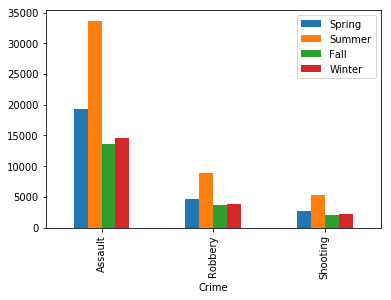

In [80]:
crimesCountBySeason.plot.bar()

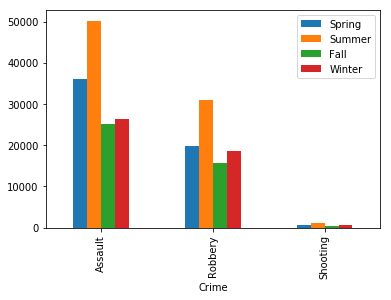

In [47]:
phili = cities['Philadelphia, PA']
phili.load_crime().load_weather().merge_dfs()
seasonalDFV = phili.dfv

springStartMonth = 3
springEndMonth = 5

summerStart = 6
summerEnd = 9
fallStart = 10
fallEnd = 11
winterStart =12
winterEnd = 3


SpringMask = (seasonalDFV.index.month >= springStartMonth) & (seasonalDFV.index.month <= springEndMonth) 
summerMask =(seasonalDFV.index.month >= summerStart ) & (seasonalDFV.index.month <= summerEnd)
fallMask= (seasonalDFV.index.month >= fallStart) & (seasonalDFV.index.month <= fallEnd)
wintMask = (seasonalDFV.index.month < winterEnd) | (seasonalDFV.index.month >= winterStart) 

winterDF = pd.DataFrame(seasonalDFV.loc[wintMask].Crime.value_counts())
springDF = pd.DataFrame(seasonalDFV.loc[SpringMask].Crime.value_counts())
summerDF = pd.DataFrame(seasonalDFV.loc[summerMask].Crime.value_counts())
fallDF = pd.DataFrame(seasonalDFV.loc[fallMask].Crime.value_counts())

#winterDF = winterDF.drop('Arson')
springDF = springDF.drop('Arson')
summerDF = summerDF.drop('Arson')
fallDF = fallDF.drop('Arson')

winterDF = winterDF.rename(columns={'Crime':'Winter'})
summerDF = summerDF.rename(columns={'Crime':'Summer'})
springDF = springDF.rename(columns={'Crime':'Spring'})
fallDF = fallDF.rename(columns={'Crime':'Fall'})

fallDF = fallDF.merge(winterDF, left_index=True, right_index=True,how='left')
springDF = springDF.merge(summerDF,left_index=True,right_index=True,how='left')
springDF = springDF.merge(fallDF,left_index=True,right_index=True,how='left')
crimesCountBySeason = springDF
crimesCountBySeason.index.name = 'Crime'

crimesCountBySeason.plot.bar()

### Results and Conclusions <a class="anchor" id="results"></a>